# Conectando ao drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importações

In [3]:
!pip install geopandas

import numpy as np
import pandas as pd 
import geopandas

# Leitura dos dados

## Limite Fortaleza

In [0]:
rm_fortaleza = geopandas.read_file('/content/drive/My Drive/CNPJ/data/limite_fortaleza.geojson')

In [5]:
rm_fortaleza

,id,GID,NOME,geometry
0,Limite Municipal de Fortaleza.fid-2be50750_153...,1,Cascavel,"MULTIPOLYGON (((-38.22795 -4.20602, -38.22813 ..."
1,Limite Municipal de Fortaleza.fid-2be50750_153...,3,Chorozinho,"MULTIPOLYGON (((-38.53970 -4.35050, -38.54670 ..."
2,Limite Municipal de Fortaleza.fid-2be50750_153...,4,Caucaia,"MULTIPOLYGON (((-38.63916 -3.68713, -38.63854 ..."
3,Limite Municipal de Fortaleza.fid-2be50750_153...,7,Aquiraz,"MULTIPOLYGON (((-38.36041 -3.88495, -38.35456 ..."
4,Limite Municipal de Fortaleza.fid-2be50750_153...,10,Eusébio,"MULTIPOLYGON (((-38.43405 -3.89269, -38.43408 ..."
5,Limite Municipal de Fortaleza.fid-2be50750_153...,9,Horizonte,"MULTIPOLYGON (((-38.37658 -4.11035, -38.38100 ..."
6,Limite Municipal de Fortaleza.fid-2be50750_153...,15,Fortaleza,"MULTIPOLYGON (((-38.63044 -3.79056, -38.62702 ..."
7,Limite Municipal de Fortaleza.fid-2be50750_153...,2,Pacajus,"MULTIPOLYGON (((-38.39353 -4.22422, -38.39362 ..."
8,Limite Municipal de Fortaleza.fid-2be50750_153...,8,Pindoretama,"MULTIPOLYGON (((-38.35163 -4.04844, -38.34897 ..."
9,Limite Municipal de Fortaleza.fid-2be50750_153...,5,Maranguape,"MULTIPOLYGON (((-38.91722 -3.95412, -38.90597 ..."


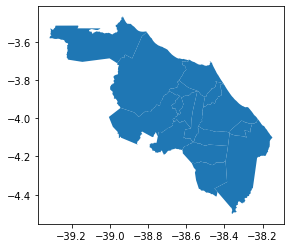

In [6]:
rm_fortaleza.plot()

## Dados CNPJ

In [7]:
path = "/content/drive/My Drive/CNPJ/data/dados_cnpj_fortaleza_enderecos.csv"

data = pd.read_csv(path, encoding="ISO-8859-1")
print("Quantidade de dados: ", len(data))

data = data[['capital_social', 'cnae_fiscal', 'cnpj', 'cod_nat_juridica', 'matriz_filial', 'motivo_situacao', 'nome_fantasia', 'opc_simples', 'porte', 'qualif_resp', 'razao_social', 'situacao', 'telefone_1', 'telefone_2', 'data_inicio_ativ', 'data_situacao', 'email', 'endereco', 'lat', 'lon']]
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Quantidade de dados:  514576


,capital_social,cnae_fiscal,cnpj,cod_nat_juridica,matriz_filial,motivo_situacao,nome_fantasia,opc_simples,porte,qualif_resp,razao_social,situacao,telefone_1,telefone_2,data_inicio_ativ,data_situacao,email,endereco,lat,lon
0,0.0,9430800,508605031,3999,1,71,0,0,5,16,ASSOCIACAO DOS ROTARIANOS DO ROTARY CLUB FORTA...,8,0,0,19970225,20081231,0,"RUA SENADOR POMPEU, 1539, CENTRO, FORTALEZA, C...",-3.733384,-38.531544
1,200000.0,8610101,991604972,2240,1,1,0,0,1,49,AMH ASSISTENCIA MEDICO HOSPITALAR S/C LTDA,8,0,0,19970210,20190409,0,"RUA JOSE LOURENCO, 531, MEIRELES, FORTALEZA, C...",-3.730451,-38.521797
2,0.0,9430800,1679604964,3999,1,71,ASSOCIACAO SANTA EDWIRGES,0,5,16,ASSOCIACAO DE CONFECCIONISTAS DE FORTALEZA DO ...,8,0,0,19970409,20081231,0,"RUA VIA FERREA SOBRAL, 5381, ANTONIO BEZERRA, ...",-3.730451,-38.521797
3,0.0,6911701,1688604964,2232,1,0,0,0,5,49,ROCHA ARAUJO E ARRAIS ADVOGADOS ASSOCIADOS,2,0,0,19970418,20051103,0,"AVENIDA SANTOS DUMONT, 1687, ALDEOTA, FORTALEZ...",-3.736211,-38.498325
4,0.0,4615000,1790604981,2062,1,1,MOVEIS FLORENSE,0,1,49,FLORENSE NORDESTE SERVICOS E REPRESENTACOES LTDA,8,32641323,0,19970429,20091120,0,"RUA EDUARDO SALGADO, 443, ALDEOTA, FORTALEZA, ...",-3.734004,-38.508760


# Tratando os Outs points

## Pegando os indices dos outs points

In [0]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Rascunho

# lat, lon = data.loc[0]['lat'], data.loc[0]['lon']
# lat, lon

# pont = Point(lon, lat)

# poly = rm_fortaleza[rm_fortaleza['NOME'] == 'Fortaleza'].reset_index()['geometry'][0]
# poly

# poly.contains(pont)

In [0]:
def get_indexes_out_points(data):
    indexes = []
    for index, row_df in list(data.iterrows()):
        point =  Point(row_df['lon'], row_df['lat'])
        contains = False
        for _, row in rm_fortaleza.iterrows():
            poly = row.geometry
            if poly.contains(point):
                contains = True
                break
        if contains == False:   
            # Tratar o dado fora
            indexes.append(index)
    return indexes

In [28]:
indexes = get_indexes_out_points(data[0:1500])

[]

## Tratando os out points

In [30]:
!pip install geopy
from geopy.geocoders import Nominatim
import time
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent= 'myGeocoder')

In [0]:
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
fortaleza = geocode('Fortaleza') # pegando coordenadas de Fortaleza

teste = []
for index in indexes:
    try: # Tenta pegar a localização pelo endereço
        location = geocode(data['endereco'].loc[index])
        teste.append((location.latitude, location.longitude))
    except:
        try: # Caso não dê certo, pega a localização do Bairro em Fortaleza
            location = geocode(str(data['bairro'].loc[index]) +', Ceara')
            teste.append((location.latitude, location.longitude))
        except: # Caso não dê certo, pega a localização de Fortaleza
            location = fortaleza
            teste.append((location.latitude, location.longitude))

for index, i in enumerate(indexes): # Preenchimento dos dados no dataset original
    data['lat'][i] = teste[index][0]
    data['lon'][i] = teste[index][1]

In [0]:
data.to_csv(path)